In [1]:
import os
import pandas as pd 
import numpy as np
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.arima_model import ARIMA
import math

import matplotlib.pylab as plt
# %matplotlib inline

In [2]:
os.chdir('..')

In [3]:
! pwd

/Users/A.IVA/Documents/jupyter_notebooks/rest/coursera_and_blogs/time_series


### 1 AR

##### 1.1 Load data

In [4]:
data_dir = os.path.join('data', 'kaggle_stocks', 'Stocks')

dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')

data = pd.read_csv(os.path.join(data_dir, 'tsla.us.txt'), index_col=0, date_parser=dateparse)

train = data['Open']['2014-07-01':'2017-04-01'].values
test = data['Open']['2017-04-01':].values[:50]

display(data.head(2))
display(data.tail(2))

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-06-28,17.0,17.0,17.00,17.00,0,0
2010-06-29,19.0,25.0,17.54,23.89,18783276,0


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2017-11-09,302.5,304.46,296.30,302.99,5440335,0
2017-11-10,302.5,308.36,301.85,302.99,4621912,0


In [5]:
from statsmodels.tsa.ar_model import AR
model_ar = AR(endog=train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)

##### 1.2 Save a model

In [6]:
from statsmodels.tsa.ar_model import AR

model_ar = AR(endog=train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)

model_ar_dir = ('model_3_ar_arima_etx')
if not os.path.exists(model_ar_dir):
    os.makedirs(model_ar_dir)

model_ar_result.save( os.path.join(model_ar_dir, 'model_ar.pickle'), remove_data=False)

##### 1.3 Algorithm check

In [10]:
print('model parameters')
print(model_ar_result.params)

print('\nbeginning (first entry can not be predicted)')
print(model_ar.predict(model_ar_result.params, start=1,end=3))
print(model_ar_result.predict(                 start=1,end=3))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[:3]).reshape(-1))

print('\nend') 
print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[-4:-1]).reshape(-1))

print('\nout of sample predictions') 
print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))

# manual out of sample calculation
v1 = model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[-1]
v2 = model_ar_result.params[0] + model_ar_result.params[1]*v1
v3 = model_ar_result.params[0] + model_ar_result.params[1]*v2
print(np.array([v1, v2, v3]).reshape(-1))

model parameters
[5.219234   0.97721209]

beginning (first entry can not be predicted)
[242.15407739 240.39509563 231.38520016]
[242.15407739 240.39509563 231.38520016]
[242.15407739 240.39509563 231.38520016]

end
[275.92652723 277.21644719 276.92328356]
[275.92652723 277.21644719 276.92328356]
[275.92652723 277.21644719 276.92328356]

out of sample predictions
[277.5975599  276.49092575 275.40950947]
[277.5975599  276.49092575 275.40950947]
[277.5975599  276.49092575 275.40950947]


##### 1.4 Load a model

In [11]:
from statsmodels.tsa.ar_model import ARResults

something = ARResults.load(os.path.join(model_ar_dir, 'model_ar.pickle'))

print('the new thing is an instance of class \t', type(something))
print(something.predict(start=1,end=3, dynamic=False))
print(something.predict(start=train.shape[0]-3,end=train.shape[0]-1))

the new thing is an instance of class 	 <class 'statsmodels.tsa.ar_model.ARResultsWrapper'>
[242.15407739 240.39509563 231.38520016]
[275.92652723 277.21644719 276.92328356]


##### 1.5 One step forward prediction and continuous update

Look at the case where you want to predict the `T`-th out of training sample value,   
by using the real/observed `T, T-1, T-2, ..` values.     
Apparently, the only, way to achieve this is to:  
 1. include the newly obeserved value to the rest of obeserved value to the previous values that are used to fit the model  
 2. train the model again using the new slightly larger data set .  
 3. make a `prediction` for the next step and add the `observed`/`real` value to the data used for training as in step 1.

In [12]:
# Option 1
import time

model_ar = AR(endog=train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
print('model parameters by using only the training data', model_ar_result.params)

a = time.time()
for i in range(len(test)):
    
    new_entry = model_ar_result.predict(start=model_ar.endog.shape[0], end=model_ar.endog.shape[0])
    
    model_ar.endog = np.append(model_ar.endog, test[i].reshape(1,-1), axis=0)
    
    model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
    
print('model parameters by using training + testing data', model_ar_result.params)
b = time.time()
print(b-a)

model parameters by using only the training data [5.219234   0.97721209]
model parameters by using training + testing data [1.2546128  0.99533369]
27.750532150268555


In [13]:
# Option 2 (use previous predicitons as an initial state for the next fit operation)

model_ar = AR(endog=train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
print('model parameters by using only the training data', model_ar_result.params)

a = time.time()
for i in range(len(test)):
    
    new_entry = model_ar_result.predict(start=model_ar.endog.shape[0], end=model_ar.endog.shape[0])
    
    model_ar.endog = np.append(model_ar.endog, test[i].reshape(1,-1), axis=0)
    
    model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100, start_params=model_ar_result.params)
    
print('model parameters by using training + testing data', model_ar_result.params)
b = time.time()
print(b-a)

model parameters by using only the training data [5.219234   0.97721209]
model parameters by using training + testing data [1.2546128  0.99533369]
27.509963035583496


In [14]:
# Option 3 : instead of playing with the endogen variables we could just initialize a new model

model_ar = AR(endog=train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
print('model parameters by using only the training data', model_ar_result.params)

for i in range(len(test)):
    
    new_entry = model_ar_result.predict( start=model_ar.endog.shape[0],end=model_ar.endog.shape[0])
    model_ar = AR(endog=np.append(model_ar.endog.reshape(-1), test[i].reshape(-1)))
    model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
    
print('model parameters by using training + testing data', model_ar_result.params)

model parameters by using only the training data [5.219234   0.97721209]
model parameters by using training + testing data [1.2546128  0.99533369]


In [15]:
# Check if the approaches above make sence by fitting directly with train + test 

model_ar = AR(endog=np.append(train, test))
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
model_ar_result.params

array([1.2546128 , 0.99533369])

##### 1.6 Other potential cool methods to check

With the `initialize()` method you can set only `self.params`, `self.model` and `self.k_constant`

Select order    
The order selection is also done while applying the `fit()` method.

In [16]:
model_ar = AR(endog=np.append(train, test))
model_ar.select_order(maxlag=10, ic='aic', trend='c')

1

Other methods/< I have forgotten the word>

In [21]:
print(model_ar_result.nobs, model_ar_result.n_totobs, model_ar_result.params)
print('\n')
print(model_ar.data.xnames, model_ar.data.ynames, model_ar.data.attach_rows(np.array([100,101])))

743 744 [1.2546128  0.99533369]


None y [100 101]


In [19]:
model_ar_result.X[:3]

array([[  1.  , 242.46],
       [  1.  , 240.66],
       [  1.  , 231.44]])

In [20]:
model_ar.data.endog[:3]

array([242.46, 240.66, 231.44])

In [ ]:
# model_ar_2.from_formula() # not tested
# model_ar.data.attach_rows() # mo success

##### 1.7 Test how everything works with time series with `Integer64` index

In [47]:
df_train_test = data['Open']['2014-07-01':'2017-06-13'].reset_index(drop=True).copy() # this is a closed interval !!!
df_train = df_train_test[:-50].copy()
df_test = df_train_test[-50:].copy()

In [48]:
from statsmodels.tsa.ar_model import AR
model_ar = AR(endog=df_train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)

`model_ar_result.params` is a `Series` object.    
`model_ar.predict()` returns arrays, `model_ar_result.predict()` returns `Series`.     
The fucntion `# _ar_predict_out_of_sample()` fails for out of sample predictions.     


In [59]:
print('model parameters')
print(model_ar_result.params)

print('\nbeginning (first entry can not be predicted)')
print(model_ar.predict(model_ar_result.params, start=1,end=3))
print(model_ar_result.predict(                 start=1,end=3))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[:3]).reshape(-1))

print('\nend') 
print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[-4:-1]).reshape(-1))

print('\nout of sample predictions; THIS CASE IS NOT WELL HANDLED by the model (only by model_Result)') 
# print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))

# manual out of sample calculation
v1 = model_ar_result.params['const'] + model_ar_result.params['L1.Open']*model_ar.endog[-1]
v2 = model_ar_result.params['const'] + model_ar_result.params['L1.Open']*v1
v3 = model_ar_result.params['const'] + model_ar_result.params['L1.Open']*v2
print(np.array([v1, v2, v3]).reshape(-1))

model parameters
const      5.219234
L1.Open    0.977212
dtype: float64

beginning (first entry can not be predicted)
[242.15407739 240.39509563 231.38520016]
1    242.154077
2    240.395096
3    231.385200
dtype: float64
[242.15407739 240.39509563 231.38520016]

end
[275.92652723 277.21644719 276.92328356]
691    275.926527
692    277.216447
693    276.923284
dtype: float64
[275.92652723 277.21644719 276.92328356]

out of sample predictions; THIS CASE IS NOT WELL HANDLED by the model (only by model_Result)
694    277.597560
695    276.490926
696    275.409509
dtype: float64
[277.5975599  276.49092575 275.40950947]


In [92]:
# Option 3 : instead of playing with the endogen variables we could just initialize a new model

model_ar = AR(endog=df_train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
new_train = df_train.copy()
print('model parameters by using only the training data\n', model_ar_result.params)

for i in range(len(test)):
    
    new_entry = model_ar_result.predict( start=model_ar.endog.shape[0],end=model_ar.endog.shape[0])
    new_train = new_train.append(df_test.iloc[i:i+1])
    
    model_ar = AR(endog=new_train)    
    model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
    
print('model parameters by using training + testing data\n', model_ar_result.params)

model parameters by using only the training data
 const      5.219234
L1.Open    0.977212
dtype: float64
model parameters by using training + testing data
 const      1.254613
L1.Open    0.995334
dtype: float64


In [93]:
model_ar = AR(endog=df_train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
new_train = df_train.copy()
print('model parameters by using only the training data\n', model_ar_result.params)

model parameters by using only the training data
 const      5.219234
L1.Open    0.977212
dtype: float64


##### 1.8 Test how everything works with time series with `datetime` index

In [102]:
from statsmodels.tsa.ar_model import AR
import datetime

In [114]:
df_train_test = data['Open']['2014-07-01':'2017-06-13'].reset_index(drop=True).copy()
df_train_test.index = [datetime.datetime(2000, 2, 3) + datetime.timedelta(days=i) for i in range(len(df_train_test))]

df_train = df_train_test[:-50].copy()
df_test = df_train_test[-50:].copy()

In [116]:
model_ar = AR(endog=df_train, freq='D')
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)

In [117]:
print('model parameters')
print(model_ar_result.params)

model parameters
const      5.219234
L1.Open    0.977212
dtype: float64


In [122]:
print('\nbeginning (first entry can not be predicted)')
print(model_ar.predict(model_ar_result.params, start=1,end=3))
print(model_ar_result.predict(                 start=1,end=3))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[:3]).reshape(-1))

print('\nend') 
print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[-4:-1]).reshape(-1))

print('\nout of sample predictions; THIS CASE IS NOT WELL HANDLED by the model (only by model_Result)') 
# print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))

# manual out of sample calculation
v1 = model_ar_result.params['const'] + model_ar_result.params['L1.Open']*model_ar.endog[-1]
v2 = model_ar_result.params['const'] + model_ar_result.params['L1.Open']*v1
v3 = model_ar_result.params['const'] + model_ar_result.params['L1.Open']*v2
print(np.array([v1, v2, v3]).reshape(-1))


beginning (first entry can not be predicted)
[242.15407739 240.39509563 231.38520016]
2000-02-04    242.154077
2000-02-05    240.395096
2000-02-06    231.385200
Freq: D, dtype: float64
[242.15407739 240.39509563 231.38520016]

end
[275.92652723 277.21644719 276.92328356]
2001-12-25    275.926527
2001-12-26    277.216447
2001-12-27    276.923284
Freq: D, dtype: float64
[275.92652723 277.21644719 276.92328356]

out of sample predictions; THIS CASE IS NOT WELL HANDLED by the model (only by model_Result)
2001-12-28    277.597560
2001-12-29    276.490926
2001-12-30    275.409509
Freq: D, dtype: float64
[277.5975599  276.49092575 275.40950947]


##### 1.9 Test how everything works with time series with `datetime` index (missing indices)

In [141]:
df_train_test = data['Open']['2014-07-01':'2017-06-13'].reset_index(drop=True).copy()
df_train_test.index = [datetime.datetime(2000, 2, 3) + datetime.timedelta(days=i) for i in range(len(df_train_test)+1) if i != 20]

df_train = df_train_test[:-50].copy()
df_test  = df_train_test[-50:].copy()

df_train = df_train.asfreq('D', method='backfill') # another option is df_train.resample('D').mean() if we want to look at larger time steps
df_test  = df_test.asfreq('D', method='backfill')

In [143]:
model_ar = AR(endog=df_train, freq='D')
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)

In [144]:
print('model parameters')
print(model_ar_result.params)

print('\nbeginning (first entry can not be predicted)')
print(model_ar.predict(model_ar_result.params, start=1,end=3))
print(model_ar_result.predict(                 start=1,end=3))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[:3]).reshape(-1))

print('\nend') 
print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[-4:-1]).reshape(-1))

print('\nout of sample predictions; THIS CASE IS NOT WELL HANDLED by the model (only by model_Result)') 
# print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))

# manual out of sample calculation
v1 = model_ar_result.params['const'] + model_ar_result.params['L1.Open']*model_ar.endog[-1]
v2 = model_ar_result.params['const'] + model_ar_result.params['L1.Open']*v1
v3 = model_ar_result.params['const'] + model_ar_result.params['L1.Open']*v2
print(np.array([v1, v2, v3]).reshape(-1))

model parameters
const      5.218590
L1.Open    0.977214
dtype: float64

beginning (first entry can not be predicted)
[242.15386664 240.39488166 231.38496969]
2000-02-04    242.153867
2000-02-05    240.394882
2000-02-06    231.384970
Freq: D, dtype: float64
[242.15386664 240.39488166 231.38496969]

end
[275.92637831 277.21630063 276.92313646]
2001-12-26    275.926378
2001-12-27    277.216301
2001-12-28    276.923136
Freq: D, dtype: float64
[275.92637831 277.21630063 276.92313646]

out of sample predictions; THIS CASE IS NOT WELL HANDLED by the model (only by model_Result)
2001-12-29    277.597414
2001-12-30    276.490635
2001-12-31    275.409076
Freq: D, dtype: float64
[277.59741404 276.49063532 275.40907579]


### 2 ARMA

##### 2.1  Load data

In [9]:
data_dir = os.path.join('data', 'kaggle_stocks', 'Stocks')

dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')

data = pd.read_csv(os.path.join(data_dir, 'tsla.us.txt'), index_col=0, date_parser=dateparse)

train = data['Open']['2014-07-01':'2017-04-01'].values
test = data['Open']['2017-04-01':].values[:50]

display(data.head(2))
display(data.tail(2))

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-06-28,17.0,17.0,17.00,17.00,0,0
2010-06-29,19.0,25.0,17.54,23.89,18783276,0


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2017-11-09,302.5,304.46,296.30,302.99,5440335,0
2017-11-10,302.5,308.36,301.85,302.99,4621912,0


##### 2.2 Save a model

There is no automatic order `(p,q)` selection !    
Therefore no option to set the criteria for picking the best option.    
... and no need to set the `maxlag`

In [10]:
from statsmodels.tsa.arima_model import ARMA

model_arma = ARMA(endog=train, order=(1,1))
model_arma_result = model_arma.fit(trend='c', maxiter=1000)

model_arma_dir = ('model_3_ar_arima_etx')
if not os.path.exists(model_arma_dir):
    os.makedirs(model_arma_dir)

model_arma_result.save( os.path.join(model_arma_dir, 'model_arma.pickle'), remove_data=False)

##### 2.3 Algorithm check

In [11]:
print('model parameters')
print(model_arma_result.params)

model parameters
[ 2.30596725e+02  9.77693177e-01 -2.98982933e-02]


In [57]:
print('\nbeginning (first entry can not be predicted)')
print(model_arma.predict(model_arma_result.params, start=0,end=4))
print(model_arma_result.predict(                   start=0,end=4))

y_hat_0 = model_arma_result.params[0] + model_arma_result.params[1]*0 + model_arma_result.params[2]*0
e_hat_0 = train[0]-y_hat_0
print(y_hat_0, e_hat_0, model_arma_result.resid[0])
# maybe some modified version of the error was used for the first `q` errors=
print(model_arma_result.params[0] + model_arma_result.params[1]*(train[0]-model_arma_result.params[0]) + model_arma_result.params[2]*e_hat_0)
e_hat_1 = model_arma_result.resid[1]
print(model_arma_result.params[0] + model_arma_result.params[1]*(train[1]-model_arma_result.params[0]) + model_arma_result.params[2]*e_hat_1)
e_hat_2 = model_arma_result.resid[2]
print(model_arma_result.params[0] + model_arma_result.params[1]*(train[2]-model_arma_result.params[0]) + model_arma_result.params[2]*e_hat_2)
e_hat_3 = model_arma_result.resid[3]
print(model_arma_result.params[0] + model_arma_result.params[1]*(train[3]-model_arma_result.params[0]) + model_arma_result.params[2]*e_hat_3)

print('\nend') 
print(model_arma.predict(model_arma_result.params, start=model_arma.endog.shape[0]-3,end=model_arma.endog.shape[0]-1))
print(model_arma_result.predict(                   start=model_arma.endog.shape[0]-3,end=model_arma.endog.shape[0]-1))
print(model_arma_result.params[0] + model_arma_result.params[1]*(train[-4]-model_arma_result.params[0]) + model_arma_result.params[2]*model_arma_result.resid[-4])
print(model_arma_result.params[0] + model_arma_result.params[1]*(train[-3]-model_arma_result.params[0]) + model_arma_result.params[2]*model_arma_result.resid[-3])
print(model_arma_result.params[0] + model_arma_result.params[1]*(train[-2]-model_arma_result.params[0]) + model_arma_result.params[2]*model_arma_result.resid[-2])

print('\nout of sample predictions') 
print(model_arma.predict(model_arma_result.params, start=model_arma.endog.shape[0],end=model_arma.endog.shape[0]+2))
print(model_arma_result.predict(                   start=model_arma.endog.shape[0],end=model_arma.endog.shape[0]+2))

y_n_1 = model_arma_result.params[0] + model_arma_result.params[1]*(train[-1]-model_arma_result.params[0]) + model_arma_result.params[2]*model_arma_result.resid[-1]
y_n_2 = model_arma_result.params[0] + model_arma_result.params[1]*(y_n_1-model_arma_result.params[0])
y_n_3 = model_arma_result.params[0] + model_arma_result.params[1]*(y_n_2-model_arma_result.params[0])
print(y_n_1, y_n_2, y_n_3)


beginning (first entry can not be predicted)
[230.59672543 242.17876459 240.48089012 231.6914962  227.69439669]
[230.59672543 242.17876459 240.48089012 231.6914962  227.69439669]
230.5967254250565 11.863274574943517 11.863274574943517
241.84067636753826
240.48092878205932
231.6914964081344
227.694396689746

end
[275.46859702 277.18914916 276.95625227]
[275.46859702 277.18914916 276.95625227]
275.4685970151954
277.18914916363195
276.9562522714625

out of sample predictions
[277.60326752 276.55470089 275.52952446]
[277.60326752 276.55470089 275.52952446]
277.60326752140605 276.55470089497766 275.5295244589573


##### 2.5 One step forward prediction and continuous update

In [58]:
# Option 3 : instead of playing with the endogen variables we could just initialize a new model
order_model=(1,1)

model_arma = ARMA(endog=train, order=order_model)
model_arma_result = model_arma.fit(maxlag=100, ic='aic', trend='c', maxiter=1000)
print('model parameters by using only the training data', model_arma_result.params)

for i in range(len(test)):
    
    new_entry = model_arma_result.predict( start=model_arma.endog.shape[0],end=model_arma.endog.shape[0])
    model_arma = ARMA(endog=np.append(model_arma.endog.reshape(-1), test[i].reshape(-1)), order=order_model)
    model_arma_result = model_arma.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
    
print('model parameters by using training + testing data', model_arma_result.params)

model parameters by using only the training data [ 2.30596725e+02  9.77693177e-01 -2.98982933e-02]
model parameters by using training + testing data [ 2.52843065e+02  9.93023411e-01 -2.81880348e-02]


In [59]:
# Check if the approaches above make sence by fitting directly with train + test 

model_arma = ARMA(endog=np.append(train, test), order=order_model)
model_arma_result = model_arma.fit(maxlag=100, ic='aic', trend='c', maxiter=1000)
model_arma_result.params

array([ 2.52843065e+02,  9.93023411e-01, -2.81880348e-02])

##### 2.6 Other potential cool methods to check

In [62]:
model_arma_result.aic, model_arma_result.bic, model_arma_result.hqic

(4767.696025585352, 4786.144189724684, 4774.807164673789)

In [74]:
import itertools
p = q = range(0, 4)
pq = list(itertools.product(p, q))

In [76]:
# pick the model with the lowest aic

for pq_el in pq:
    model_arma = ARMA(endog=np.append(train, test), order=pq_el)
    model_arma_result = model_arma.fit(trend='c', maxiter=1000)
    print(pq_el, model_arma_result.aic)

(0, 0) 7372.393113376376
(0, 1) 6536.708965148451
(0, 2) 5988.78129055012
(0, 3) 5675.959343248822
(1, 0) 4766.302742288701
(1, 1) 4767.696025585352
(1, 2) 4769.104320461249
(1, 3) 4770.849368747941
(2, 0) 4767.663054714243
(2, 1) 4769.174261617076
(2, 2) 4770.75965034263
(2, 3) 4772.593107633718
(3, 0) 4769.157664798933
(3, 1) 4771.030418972355
(3, 2) 4770.561888743701
(3, 3) 4774.316334403911


### 3 ARIMA

##### 3.1 Load data

In [15]:
data_dir = os.path.join('data', 'kaggle_stocks', 'Stocks')

dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')

data = pd.read_csv(os.path.join(data_dir, 'tsla.us.txt'), index_col=0, date_parser=dateparse)

train = data['Open']['2014-07-01':'2017-04-01'].values
test = data['Open']['2017-04-01':].values[:50]

display(data.head(2))
display(data.tail(2))

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-06-28,17.0,17.0,17.00,17.00,0,0
2010-06-29,19.0,25.0,17.54,23.89,18783276,0


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2017-11-09,302.5,304.46,296.30,302.99,5440335,0
2017-11-10,302.5,308.36,301.85,302.99,4621912,0


##### 3.2 Save a model

In [16]:
from statsmodels.tsa.arima_model import ARIMA

model_arima = ARIMA(endog=train, order=(1,0,1))
model_arima_result = model_arima.fit(trend='c', maxiter=1000)

model_arima_dir = ('model_3_ar_arima_etx')
if not os.path.exists(model_arima_dir):
    os.makedirs(model_arima_dir)

model_arima_result.save( os.path.join(model_arima_dir, 'model_arima.pickle'), remove_data=False)

##### 3.3 Algorithm check

Consider first the case where `(p,d,q) = (1,0,1)`

In [17]:
print('model parameters')
print(model_arima_result.params)

model parameters
[ 2.30596725e+02  9.77693177e-01 -2.98982933e-02]


In [18]:
train.shape, model_arima.endog.shape

((694,), (694,))

In [19]:
print('\nbeginning (first entry can not be predicted)')
print(model_arima.predict(model_arima_result.params, start=0,end=4))
print(model_arima_result.predict(                    start=0,end=4))

y_hat_0 = model_arima_result.params[0] + model_arima_result.params[1]*0 + model_arima_result.params[2]*0
e_hat_0 = train[0]-y_hat_0
print(y_hat_0, e_hat_0, model_arima_result.resid[0])
# maybe some modified version of the error was used for the first `q` errors=
print(model_arima_result.params[0] + model_arima_result.params[1]*(train[0]-model_arima_result.params[0]) + model_arima_result.params[2]*e_hat_0)
e_hat_1 = model_arima_result.resid[1]
print(model_arima_result.params[0] + model_arima_result.params[1]*(train[1]-model_arima_result.params[0]) + model_arima_result.params[2]*e_hat_1)
e_hat_2 = model_arima_result.resid[2]
print(model_arima_result.params[0] + model_arima_result.params[1]*(train[2]-model_arima_result.params[0]) + model_arima_result.params[2]*e_hat_2)
e_hat_3 = model_arima_result.resid[3]
print(model_arima_result.params[0] + model_arima_result.params[1]*(train[3]-model_arima_result.params[0]) + model_arima_result.params[2]*e_hat_3)

print('\nend') 
print(model_arima.predict(model_arima_result.params, start=model_arima.endog.shape[0]-3,end=model_arima.endog.shape[0]-1))
print(model_arima_result.predict(                    start=model_arima.endog.shape[0]-3,end=model_arima.endog.shape[0]-1))
print(model_arima_result.params[0] + model_arima_result.params[1]*(train[-4]-model_arima_result.params[0]) + model_arima_result.params[2]*model_arima_result.resid[-4])
print(model_arima_result.params[0] + model_arima_result.params[1]*(train[-3]-model_arima_result.params[0]) + model_arima_result.params[2]*model_arima_result.resid[-3])
print(model_arima_result.params[0] + model_arima_result.params[1]*(train[-2]-model_arima_result.params[0]) + model_arima_result.params[2]*model_arima_result.resid[-2])

print('\nout of sample predictions') 
print(model_arima.predict(model_arima_result.params, start=model_arima.endog.shape[0],end=model_arima.endog.shape[0]+2))
print(model_arima_result.predict(                    start=model_arima.endog.shape[0],end=model_arima.endog.shape[0]+2))


y_n_1 = model_arima_result.params[0] + model_arima_result.params[1]*(train[-1]- model_arima_result.params[0]) + model_arima_result.params[2]*model_arima_result.resid[-1]
y_n_2 = model_arima_result.params[0] + model_arima_result.params[1]*(y_n_1    - model_arima_result.params[0])
y_n_3 = model_arima_result.params[0] + model_arima_result.params[1]*(y_n_2    - model_arima_result.params[0])
print(y_n_1, y_n_2, y_n_3)


beginning (first entry can not be predicted)
[230.59672543 242.17876459 240.48089012 231.6914962  227.69439669]
[230.59672543 242.17876459 240.48089012 231.6914962  227.69439669]
230.5967254250565 11.863274574943517 11.863274574943517
241.84067636753826
240.48092878205932
231.6914964081344
227.694396689746

end
[275.46859702 277.18914916 276.95625227]
[275.46859702 277.18914916 276.95625227]
275.4685970151954
277.18914916363195
276.9562522714625

out of sample predictions
[277.60326752 276.55470089 275.52952446]
[277.60326752 276.55470089 275.52952446]
277.60326752140605 276.55470089497766 275.5295244589573


Consider the case where `(p,d,q) = (1,1,1)`   
Slight differences which I can not explain.

In [20]:
model_arima = ARIMA(endog=train, order=(1,1,1))
model_arima_result = model_arima.fit(trend='c', maxiter=1000)

In [21]:
model_arima_result.params

array([ 0.05231727, -0.22121302,  0.17702628])

In [23]:
print('\nbeginning (first entry can not be predicted)')
# print(model_arima.predict(model_arima_result.params, start=1,end=4,typ='levels'))
# print(model_arima_result.predict(                    start=1,end=4,typ='levels'))
print(model_arima.predict(model_arima_result.params, start=1,end=4,typ='linear'))
print(model_arima_result.predict(                    start=1,end=4,typ='linear'))


y_hats  = np.append(np.nan, model_arima_result.predict( start=1,end=5,typ='levels'))
dy_hats = np.append(np.nan, model_arima_result.predict( start=1,end=5,typ='linear')) 
ys      = train[:5]

dy_1     = train[1] - train[0]
dy_1_hat = model_arima_result.params[0] + model_arima_result.params[1]*0 + model_arima_result.params[2]*0
y_1_hat  = train[0] + dy_1_hat
eps_1    = dy_1 - dy_hats[1] # - dy_1_hat  

dy_2     = train[2] - train[1]
dy_2_hat = model_arima_result.params[0] + model_arima_result.params[1]*(dy_1-model_arima_result.params[0]) + model_arima_result.params[2]*eps_1
y_2_hat  = train[1] + dy_2_hat
eps_2    = dy_2 - dy_hats[2]  # - dy_2_hat 

dy_3     = train[3] - train[2]
dy_3_hat = model_arima_result.params[0] + model_arima_result.params[1]*(dy_2-model_arima_result.params[0]) + model_arima_result.params[2]*eps_2
y_3_hat  = train[2] + dy_3_hat
eps_3    = dy_3 - dy_hats[3] # - dy_3_hat

dy_4     = train[4] - train[3]
dy_4_hat = model_arima_result.params[0] + model_arima_result.params[1]*(dy_3-model_arima_result.params[0]) + model_arima_result.params[2]*eps_3
y_4_hat  = train[3] + dy_4_hat
eps_4    = dy_4 - dy_4_hat

dy_5     = train[5] - train[4]
dy_5_hat = model_arima_result.params[0] + model_arima_result.params[1]*(dy_4-model_arima_result.params[0]) + model_arima_result.params[2]*eps_4
y_5_hat  = train[4] + dy_5_hat
eps_5    = dy_5 - dy_5_hat

# print(y_1_hat, y_2_hat, y_3_hat, y_4_hat, y_5_hat)
print(dy_1_hat, dy_2_hat, dy_3_hat, dy_4_hat)


beginning (first entry can not be predicted)
[0.05231727 0.13483692 0.4475289  0.15876347]
[0.05231727 0.13483692 0.4475289  0.15876347]
0.05231726849383878 0.13416512752140752 0.4474225808039234 0.15876190256139755


In [24]:
print('\nend') 
print(model_arima.predict(model_arima_result.params, start=train.shape[0]-3,end=train.shape[0]-1, typ='linear'))
print(model_arima_result.predict(                    start=train.shape[0]-3,end=train.shape[0]-1, typ='linear'))


y_hats  = model_arima_result.predict( start=1,end=train.shape[0]-1,typ='levels')
dy_hats = model_arima_result.predict( start=1,end=train.shape[0]-1,typ='linear')

dy_m4     = train[-4] - train[-5]
eps_m4    = dy_m4 - dy_hats[-4] # dy_m4 - dy_m4_hat; I do not have them so I will use a different trick

dy_m3     = train[-3] - train[-4]  # value that we want to predict 
dy_m3_hat = model_arima_result.params[0] + model_arima_result.params[1]*(dy_m4-model_arima_result.params[0]) + model_arima_result.params[2]*eps_m4
y_m3_hat  = train[-4] + dy_m3_hat
eps_m3    = dy_m3 - dy_m3_hat

dy_m2     = train[-2] - train[-3]  # value that we want to predict 
dy_m2_hat = model_arima_result.params[0] + model_arima_result.params[1]*(dy_m3-model_arima_result.params[0]) + model_arima_result.params[2]*eps_m3
y_m2_hat  = train[-3] + dy_m2_hat
eps_m2    = dy_m2 - dy_m2_hat

dy_m1     = train[-1] - train[-2]  # value that we want to predict 
dy_m1_hat = model_arima_result.params[0] + model_arima_result.params[1]*(dy_m2-model_arima_result.params[0]) + model_arima_result.params[2]*eps_m2
y_m1_hat  = train[-2] + dy_m1_hat
eps_m1    = dy_m1 - dy_m1_hat

# print(y_m3_hat, y_m2_hat, y_m1_hat)
print(dy_m3_hat, dy_m2_hat, dy_m1_hat)


end
[-0.63191544  0.11742968  0.05635841]
[-0.63191544  0.11742968  0.05635841]
-0.6319154357553098 0.11742967500864565 0.056358412281008435


In [25]:
print('\nout of sample predictions') 
print(model_arima.predict(model_arima_result.params, start=train.shape[0],end=train.shape[0]+2))
print(model_arima_result.predict(                    start=train.shape[0],end=train.shape[0]+2))


# y_n_1 = model_arima_result.params[0] + model_arima_result.params[1]*(train[-1]- model_arima_result.params[0]) + model_arima_result.params[2]*model_arima_result.resid[-1]
# y_n_2 = model_arima_result.params[0] + model_arima_result.params[1]*(y_n_1    - model_arima_result.params[0])
# y_n_3 = model_arima_result.params[0] + model_arima_result.params[1]*(y_n_2    - model_arima_result.params[0])
# print(y_n_1, y_n_2, y_n_3)


y_hats  = model_arima_result.predict( start=1,end=train.shape[0]-1,typ='levels')
dy_hats = model_arima_result.predict( start=1,end=train.shape[0]-1,typ='linear')

dy_m1     = train[-1] - train[-2]
eps_m1    = dy_m1 - dy_hats[-1]

# first out of sample element
dy_m0_hat = model_arima_result.params[0] + model_arima_result.params[1]*(dy_m1-model_arima_result.params[0]) + model_arima_result.params[2]*eps_m1
y_m0_hat  = train[-1] + dy_m0_hat
eps_m0    = 0 # can not be estimated

# sec out of sample element
dy_n2_hat = model_arima_result.params[0] + model_arima_result.params[1]*(dy_m0_hat-model_arima_result.params[0]) + model_arima_result.params[2]*eps_m0
eps_n2    = 0 # can not be estimated

# third out of sample element
dy_n3_hat = model_arima_result.params[0] + model_arima_result.params[1]*(dy_n2_hat-model_arima_result.params[0]) + model_arima_result.params[2]*eps_n2
eps_n3    = 0 # can not be estimated

# print(y_m3_hat, y_m2_hat, y_m1_hat)
print(dy_m0_hat, dy_n2_hat, dy_n3_hat)


out of sample predictions
[0.02342476 0.05870867 0.05090341]
[0.02342476 0.05870867 0.05090341]
0.02342475963735148 0.05870866766877823 0.050903407772489744


In [ ]:
print(model_arima.predict(model_arima_result.params, start=train.shape[0],end=train.shape[0]+2))
print(model_arima_result.predict(                    start=train.shape[0],end=train.shape[0]+2))

In [89]:
model_arima_result.forecast(steps=3)

(array([278.75342476, 278.81213343, 278.86303684]),
 array([5.81111396, 8.03864018, 9.8032977 ]),
 array([[267.36385068, 290.14299884],
        [263.05668818, 294.56757867],
        [259.64892641, 298.07714726]]))

In [91]:
print(model_arima.predict(model_arima_result.params, start=train.shape[0],end=train.shape[0]+2, typ='levels'))

[278.75342476 278.81213343 278.86303684]


For `ARIMA` models with `(p,d,q)=(1,1,1)` I my predictions are always smaller than the models predictions by about `0.01`.   
The predictions are exact for the case `(p,0,q)=(1,0,1)`

##### 3.6 One step forward prediction

In [117]:
# Option 3 : instead of playing with the endogen variables we could just initialize a new model
order_model=(1,1,1)

model_arima = ARIMA(endog=train, order=order_model)
model_arima_result = model_arima.fit(trend='c', maxiter=1000)
new_train = train
print('model parameters by using only the training data', model_arma_result.params)

for i in range(len(test)):
    
    new_entry = model_arima_result.predict( start=new_train.shape[0],end=new_train.shape[0], typ='levels')
    new_train = np.append(train, test[i].reshape(-1))
    model_arima = ARIMA(endog=new_train, order=order_model)
    model_arima_result = model_arima.fit(trend='c', maxiter=1000)

print('model parameters by using training + testing data', model_arima_result.params)

model parameters by using only the training data [ 0.05231727 -0.22121302  0.17702628]
model parameters by using training + testing data [ 0.176182   -0.26820164  0.22686366]


##### 3.7 use IC to determine best parameters

In [142]:
model_arima_result.params

array([ 0.05231727, -0.22121302,  0.17702628])

In [145]:
model_arima_result.conf_int(alpha=0.05)

array([[-0.364701  ,  0.46933554],
       [-1.23768097,  0.79525492],
       [-0.84729441,  1.20134698]])

In [ ]:
# order_model=(1,1,1)

# model_arima = ARIMA(endog=train, order=order_model)
# model_arima_result = model_arima.fit(trend='c', maxiter=1000)

In [122]:
model_arima_result.aic

4638.760489216148

In [134]:
import itertools
p = range(0, 5)
d = range(0, 3)
q = range(0, 5)
list_aic = []

for pdq in list(itertools.product(p, d, q)):
    
    try:
        model_arima = ARIMA(endog=train, order=pdq)
        model_arima_result = model_arima.fit(trend='c', maxiter=1000)
        aic = model_arima_result.aic
        print('{0:s} \t aic: {1:f}'.format(str(pdq), aic)) 
    except:
        aic = None
        print('{0:s} \t aic: na'.format(str(pdq))) 
        
    list_aic.append((pdq, aic))

(0, 0, 0) 	 aic: 6487.151122
(0, 0, 1) 	 aic: 5750.019837
(0, 0, 2) 	 aic: 5305.691551
(0, 0, 3) 	 aic: 5055.758206
(0, 0, 4) 	 aic: 4861.325423
(0, 1, 0) 	 aic: 4411.118690
(0, 1, 1) 	 aic: 4411.872188
(0, 1, 2) 	 aic: 4413.360872
(0, 1, 3) 	 aic: 4414.507867
(0, 1, 4) 	 aic: 4415.868489
(0, 2, 0) 	 aic: 4914.773411
(0, 2, 1) 	 aic: 4413.714461
(0, 2, 2) 	 aic: na
(0, 2, 3) 	 aic: na
(0, 2, 4) 	 aic: na
(1, 0, 0) 	 aic: 4414.661787
(1, 0, 1) 	 aic: 4416.027800
(1, 0, 2) 	 aic: 4417.019317
(1, 0, 3) 	 aic: 4417.315176
(1, 0, 4) 	 aic: 4419.129047
(1, 1, 0) 	 aic: 4411.812722
(1, 1, 1) 	 aic: 4413.695311
(1, 1, 2) 	 aic: na
(1, 1, 3) 	 aic: na
(1, 1, 4) 	 aic: na
(1, 2, 0) 	 aic: 4686.200725
(1, 2, 1) 	 aic: 4414.444024
(1, 2, 2) 	 aic: 4416.626552
(1, 2, 3) 	 aic: 4418.086872


/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 2, 4) 	 aic: 4419.557284
(2, 0, 0) 	 aic: 4415.981818
(2, 0, 1) 	 aic: 4417.783304
(2, 0, 2) 	 aic: 4414.312564
(2, 0, 3) 	 aic: 4419.260988
(2, 0, 4) 	 aic: 4420.671863
(2, 1, 0) 	 aic: 4413.490293
(2, 1, 1) 	 aic: 4415.293643
(2, 1, 2) 	 aic: 4408.814051
(2, 1, 3) 	 aic: na
(2, 1, 4) 	 aic: na
(2, 2, 0) 	 aic: 4593.659672
(2, 2, 1) 	 aic: 4416.100704
(2, 2, 2) 	 aic: 4417.886274
(2, 2, 3) 	 aic: 4411.386941
(2, 2, 4) 	 aic: 4412.062858
(3, 0, 0) 	 aic: 4417.203451
(3, 0, 1) 	 aic: 4418.603784
(3, 0, 2) 	 aic: 4416.413174


/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(3, 0, 3) 	 aic: 4417.855488
(3, 0, 4) 	 aic: 4419.442032
(3, 1, 0) 	 aic: 4414.585437
(3, 1, 1) 	 aic: 4416.520229
(3, 1, 2) 	 aic: na
(3, 1, 3) 	 aic: 4409.098858
(3, 1, 4) 	 aic: na
(3, 2, 0) 	 aic: 4560.672981
(3, 2, 1) 	 aic: 4417.155668
(3, 2, 2) 	 aic: na
(3, 2, 3) 	 aic: na
(3, 2, 4) 	 aic: 4414.125305
(4, 0, 0) 	 aic: 4417.545737
(4, 0, 1) 	 aic: 4419.528023
(4, 0, 2) 	 aic: 4419.703309


/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 3) 	 aic: 4419.711575
(4, 0, 4) 	 aic: 4423.808017
(4, 1, 0) 	 aic: 4416.252425
(4, 1, 1) 	 aic: 4417.189970
(4, 1, 2) 	 aic: 4417.203681
(4, 1, 3) 	 aic: 4420.163038
(4, 1, 4) 	 aic: na
(4, 2, 0) 	 aic: 4548.814449
(4, 2, 1) 	 aic: 4418.856207
(4, 2, 2) 	 aic: 4420.327050
(4, 2, 3) 	 aic: na
(4, 2, 4) 	 aic: nan


/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [136]:
import operator

list_aic_filtered = list(filter(lambda x: x[1] is not None, list_aic))
min(list_aic_filtered, key=operator.itemgetter(1))

((2, 1, 2), 4408.8140510092535)

In [131]:
print('aaaa {0:f} bbb'.format(None))

TypeError: unsupported format string passed to NoneType.__format__

### 4 VAR

In [138]:
data_dir = os.path.join('data', 'kaggle_stocks', 'Stocks')

dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')

data = pd.read_csv(os.path.join(data_dir, 'tsla.us.txt'), index_col=0, date_parser=dateparse)

train = data['Open']['2014-07-01':'2017-04-01'].values
test = data['Open']['2017-04-01':].values[:50]

display(data.head(2))
display(data.tail(2))

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-06-28,17.0,17.0,17.00,17.00,0,0
2010-06-29,19.0,25.0,17.54,23.89,18783276,0


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2017-11-09,302.5,304.46,296.30,302.99,5440335,0
2017-11-10,302.5,308.36,301.85,302.99,4621912,0


### 5 TODO: try `Dynamic Vector Autoregressions` (https://www.statsmodels.org/stable/vector_ar.html#var)

Information criteria

In [104]:
print(model_arima_result.aic, model_arima_result.bic, model_arima_result.hqic)
print(model_arima_result.params)

4413.6953108595435 4431.859430856303 4420.7200680219385
[ 0.05231727 -0.22121302  0.17702628]


### 6 Generate ARMA processes and ...

##### 6.1 process generation

In [201]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [148]:
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = ArmaProcess(ar, ma)
arma_process.isstationary

True

In [195]:
y = arma_process.generate_sample(nsample=1000)
y_diff = y[1:]-y[:-1]
y_diff_x2 = y_diff[1:]-y_diff[:-1]
y_cumsum = np.cumsum(y)
y_cumsum_x2 = np.cumsum(y_cumsum)

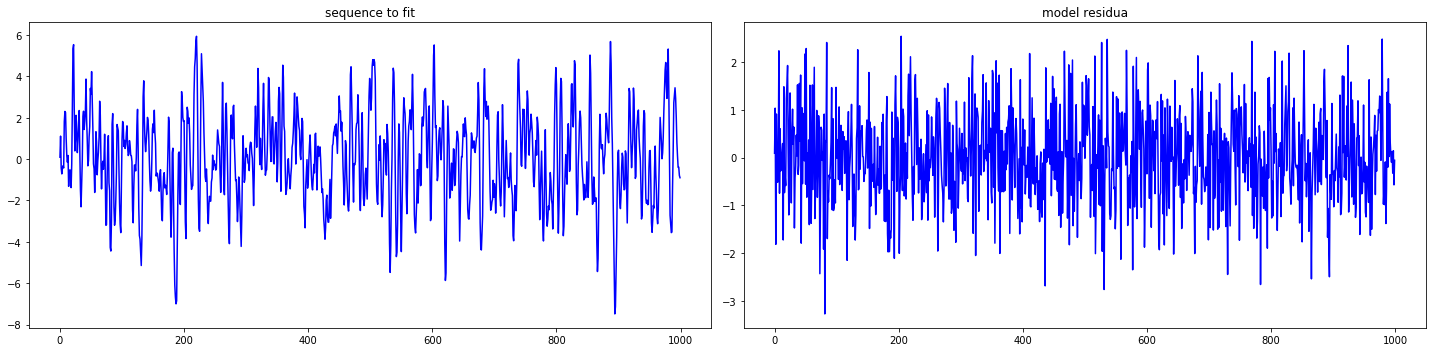

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(2, 2)   Log Likelihood               -1389.666
Method:                       css-mle   S.D. of innovations              0.970
Date:                Sun, 30 Jun 2019   AIC                           2789.331
Time:                        16:25:59   BIC                           2813.870
Sample:                             0   HQIC                          2798.658
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.8145      0.069     11.786      0.000       0.679       0.950
ar.L2.y       -0.2959      0.056     -5.266      0.000      -0.406      -0.186
ma.L1.y        0.6400      0.068      9.475      0.000       0.508       0.772
ma.L2.y        0.3506      0.049      7.110      0.000       0.254       0.447
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3761           -1.2187j            1.8382           -0.1154
AR.2            1.3761           +1.2187j            1.8382            0.1154
MA.1           -0.9127           -1.4210j            1.6889           -0.3409
MA.2           -0.9127           +1.4210j            1.6889            0.3409
-----------------------------------------------------------------------------
"""

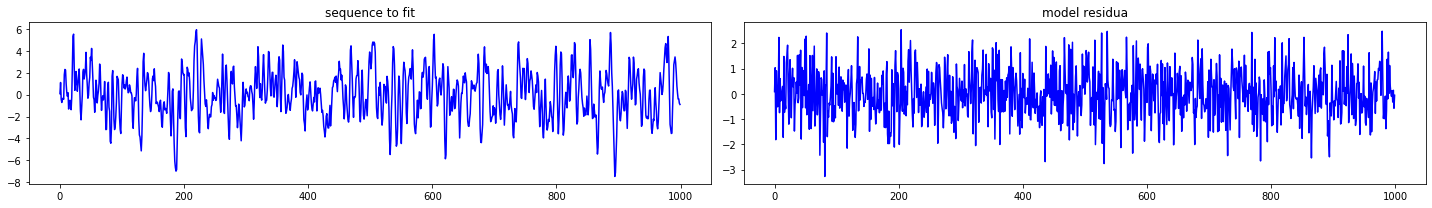

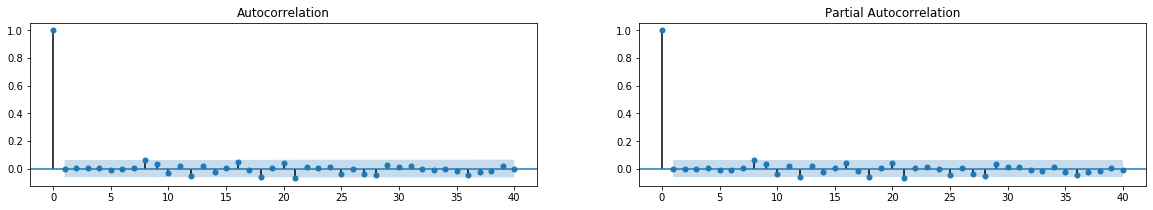

In [218]:
model_arma = ARMA(y, (2, 2))
model_arma_result = model_arma.fit(trend='nc', disp=0)
display(model_arma_result.summary())

plt.figure(figsize=(20,3))

plt.subplot(1,2,1) 
plt.plot(y, color='blue') 
plt.title('sequence to fit')

plt.subplot(1,2,2) 
plt.plot(model_arma_result.resid, color='blue') 
plt.title('model residua')
plt.tight_layout()    
plt.show()


fig = plt.figure(figsize=(20,3))
ax1 = fig.add_subplot(121)
fig = plot_acf(model_arma_result.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(122)
fig = plot_pacf(model_arma_result.resid, lags=40, ax=ax2)
plt.show()



# model_arma_result.summary2()
# model_arma_result.params

##### 6.2 Stationarity test

In [175]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [197]:
# look at the second value of every results. This has to be the p-value
# if it is below 0.05 we can reject the null hypothesis (with 95% confidence?)

display(adfuller(y))
display(adfuller(y_diff))
display(adfuller(y_cumsum)) # here we see that we are not able to reject the null hypothesis
display(adfuller(y_cumsum_x2)) # here we see that we are not able to reject the null hypothesis

(-10.010960709757015,
 1.7792249448610507e-17,
 5,
 994,
 {'1%': -3.43694584277544,
  '5%': -2.8644520725172873,
  '10%': -2.5683205291305176},
 2721.7754125934507)

(-10.101046587973679,
 1.0593003644224615e-17,
 21,
 977,
 {'1%': -3.43706091543889,
  '5%': -2.8645028204932483,
  '10%': -2.568347558984588},
 2770.677971678916)

(-2.609039251086917,
 0.09114339266139837,
 6,
 993,
 {'1%': -3.4369525024039884,
  '5%': -2.8644550095200705,
  '10%': -2.568322093455802},
 2717.8230315875026)

(1.0313780266563122,
 0.994586233949397,
 7,
 992,
 {'1%': -3.436959175494265,
  '5%': -2.8644579524531975,
  '10%': -2.568323660940752},
 2718.6756654128876)

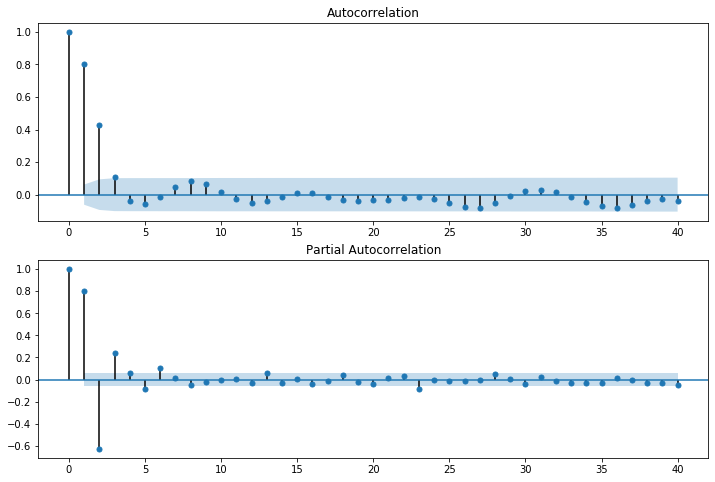

In [198]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(y, lags=40, ax=ax1, alpha=0.05)
ax2 = fig.add_subplot(212)
fig = plot_pacf(y, lags=40, ax=ax2)
plt.show()

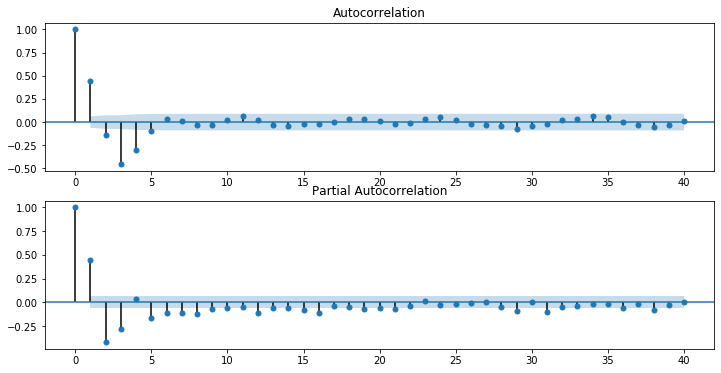

In [193]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
fig = plot_acf(y_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(y_diff, lags=40, ax=ax2)
plt.show()

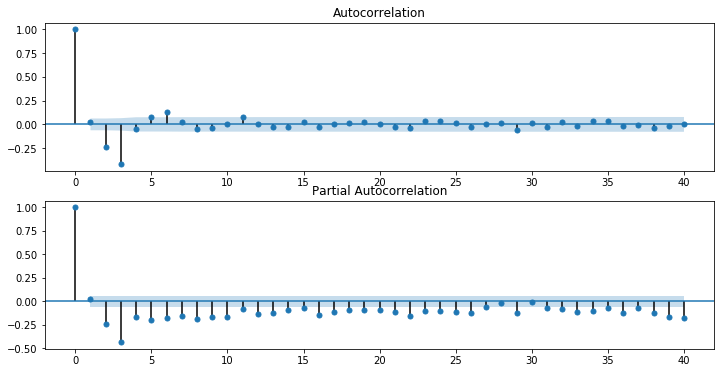

In [194]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
fig = plot_acf(y_diff_x2, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(y_diff_x2, lags=40, ax=ax2)
plt.show()

### 8 Exponential smoothing

##### 8.1 Load the data

Exponential smoothing possible only for a single time sequence, i.e. aplication to multidim data where $\alpha$ can be trun from a scalar to a matrix is not available.  

In [42]:
data_dir = os.path.join('data', 'kaggle_stocks', 'Stocks')

dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')

data = pd.read_csv(os.path.join(data_dir, 'tsla.us.txt'), index_col=0, date_parser=dateparse)

train = data['Open']['2014-07-01':'2017-04-01'].values
test = data['Open']['2017-04-01':].values[:50]

display(data.head(2))
display(data.tail(2))

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-06-28,17.0,17.0,17.00,17.00,0,0
2010-06-29,19.0,25.0,17.54,23.89,18783276,0


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2017-11-09,302.5,304.46,296.30,302.99,5440335,0
2017-11-10,302.5,308.36,301.85,302.99,4621912,0


##### 8.2 Fit & ..

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [46]:
# model_exp = ExponentialSmoothing(endog=data['2014-07-01':'2017-04-01'].values)
# model_exp.fit()

# model_exp = Holt(endog=data['2014-07-01':'2017-04-01'].values)
# model_exp.fit()

In [ ]:
fit3.forecast(3)

In [ ]:
model_arma = ARMA(endog=train, order=(1,1))
model_arma_result = model_arma.fit(trend='c', maxiter=1000)

model_arma_dir = ('model_3_ar_arima_etx')
if not os.path.exists(model_arma_dir):
    os.makedirs(model_arma_dir)

model_arma_result.save( os.path.join(model_arma_dir, 'model_arma.pickle'), remove_data=False)

### 9 Exponential smoothing

##### 9.1 Load data

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

data = [446.6565,  454.4733,  455.663 ,  423.6322,  456.2713,  440.5881, 425.3325,  485.1494,  506.0482,  526.792 ,  514.2689,  494.211 ]
index= pd.date_range(start='1996', end='2008', freq='A')
oildata = pd.Series(data, index)

data = [17.5534,  21.86  ,  23.8866,  26.9293,  26.8885,  28.8314, 30.0751,  30.9535,  30.1857,  31.5797,  32.5776,  33.4774, 39.0216,  41.3864,  41.5966]
index= pd.date_range(start='1990', end='2005', freq='A')
air = pd.Series(data, index)

data = [263.9177,  268.3072,  260.6626,  266.6394,  277.5158,  283.834 , 290.309 ,  292.4742,  300.8307,  309.2867,  318.3311,  329.3724, 338.884 ,  339.2441,  328.6006,  314.2554,  314.4597,  321.4138, 329.7893,  346.3852,  352.2979,  348.3705,  417.5629,  417.1236, 417.7495,  412.2339,  411.9468,  394.6971,  401.4993,  408.2705, 414.2428]
index= pd.date_range(start='1970', end='2001', freq='A')
livestock2 = pd.Series(data, index)

data = [407.9979 ,  403.4608,  413.8249,  428.105 ,  445.3387,  452.9942, 455.7402]
index= pd.date_range(start='2001', end='2008', freq='A')
livestock3 = pd.Series(data, index)

data = [41.7275,  24.0418,  32.3281,  37.3287,  46.2132,  29.3463, 36.4829,  42.9777,  48.9015,  31.1802,  37.7179,  40.4202, 51.2069,  31.8872,  40.9783,  43.7725,  55.5586,  33.8509, 42.0764,  45.6423,  59.7668,  35.1919,  44.3197,  47.9137]
index= pd.date_range(start='2005', end='2010-Q4', freq='QS-OCT')
aust = pd.Series(data, index)

##### 9.2 Simple exp smoothing

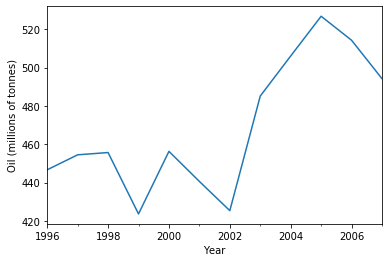

Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.


In [8]:
ax=oildata.plot()
ax.set_xlabel("Year")
ax.set_ylabel("Oil (millions of tonnes)")
plt.show()
print("Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.")

In [9]:
fit1 = SimpleExpSmoothing(oildata).fit(smoothing_level=0.2, optimized=False)
fcast1 = fit1.forecast(3).rename(r'$\alpha=0.2$')

/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:322: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = self.model._index[-1] + 1
/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:323: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  end = self.model._index[-1] + steps
/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [13]:
display(oildata)
display(fit1.fittedvalues)

1996-12-31    446.6565
1997-12-31    454.4733
1998-12-31    455.6630
1999-12-31    423.6322
2000-12-31    456.2713
2001-12-31    440.5881
2002-12-31    425.3325
2003-12-31    485.1494
2004-12-31    506.0482
2005-12-31    526.7920
2006-12-31    514.2689
2007-12-31    494.2110
Freq: A-DEC, dtype: float64

1996-12-31    446.656500
1997-12-31    446.656500
1998-12-31    448.219860
1999-12-31    449.708488
2000-12-31    444.493230
2001-12-31    446.848844
2002-12-31    445.596695
2003-12-31    441.543856
2004-12-31    450.264965
2005-12-31    461.421612
2006-12-31    474.495690
2007-12-31    482.450332
Freq: A-DEC, dtype: float64

In [10]:
fcast1

2008-12-31    484.802465
2009-12-31    484.802465
2010-12-31    484.802465
Freq: A-DEC, Name: $\alpha=0.2$, dtype: float64

In [30]:
s = [oildata.values[0]]
for x in oildata.values[:-1]:
    if s !=[]:
        s.append(alpha * x + (1-alpha)*s[-1])
    else:
        s.append(x)
        
(s - fit1.fittedvalues).sum()

0.0

All out of sample predictions are the same ....

In [36]:
alpha * oildata.values[-1] +  (1-alpha) * fit1.fittedvalues[-1] 

484.80246538161776

##### 9.3 Holt

In [77]:
hw = ExponentialSmoothing(air, trend='add', damped=False, seasonal=None)
hw_result = hw.fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
hw_forecast = hw_result.forecast(1).rename("ExponentialSmoothing = Holt's linear trend")
hw_forecast

2005-12-31    43.757004
Freq: A-DEC, Name: ExponentialSmoothing = Holt's linear trend, dtype: float64

In [74]:
hw_result.params

{'smoothing_level': 0.8,
 'smoothing_slope': 0.2,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 17.5534,
 'initial_slope': 4.3065999999999995,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [65]:
type(hw), type(hw_result)

(statsmodels.tsa.holtwinters.ExponentialSmoothing,
 statsmodels.tsa.holtwinters.HoltWintersResultsWrapper)

In [64]:
hw_forecast

2005-12-31    43.757004
2006-12-31    45.593562
2007-12-31    47.430121
2008-12-31    49.266679
2009-12-31    51.103237
Freq: A-DEC, Name: ExponentialSmoothing = Holt's linear trend, dtype: float64

From the figure below we can conclude that `Holt` is just a special case of `ExponentialSmoothing = Holt Winters's Exponential smoothing`.

Holt:
    - exponential    
    - damped    
ExponentialSmoothing:
    - trend   
    - damped   
    - seasonal   
    - seasonal_periods   

In [66]:
fit1_ = ExponentialSmoothing(air, trend='add', damped=False, seasonal=None).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1_ = fit1_.forecast(5).rename("ExponentialSmoothing = Holt's linear trend")

In [69]:
len(fit1_.fittedvalues), len(air)

(15, 15)

In [71]:
fit1_.fittedvalues

1990-12-31    21.860000
1991-12-31    22.032264
1992-12-31    25.484435
1993-12-31    27.540495
1994-12-31    30.288076
1995-12-31    30.261020
1996-12-31    31.581190
1997-12-31    32.599209
1998-12-31    33.242220
1999-12-31    32.267539
2000-12-31    33.077748
2001-12-31    33.958086
2002-12-31    34.777084
2003-12-31    40.055366
2004-12-31    43.215828
Freq: A-DEC, dtype: float64

In [73]:
fit1_.predict(start=0, end=len(air)-1)

1990-12-31    21.860000
1991-12-31    22.032264
1992-12-31    25.484435
1993-12-31    27.540495
1994-12-31    30.288076
1995-12-31    30.261020
1996-12-31    31.581190
1997-12-31    32.599209
1998-12-31    33.242220
1999-12-31    32.267539
2000-12-31    33.077748
2001-12-31    33.958086
2002-12-31    34.777084
2003-12-31    40.055366
2004-12-31    43.215828
Freq: A-DEC, dtype: float64

/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:322: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = self.model._index[-1] + 1
/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:323: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  end = self.model._index[-1] + steps
/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


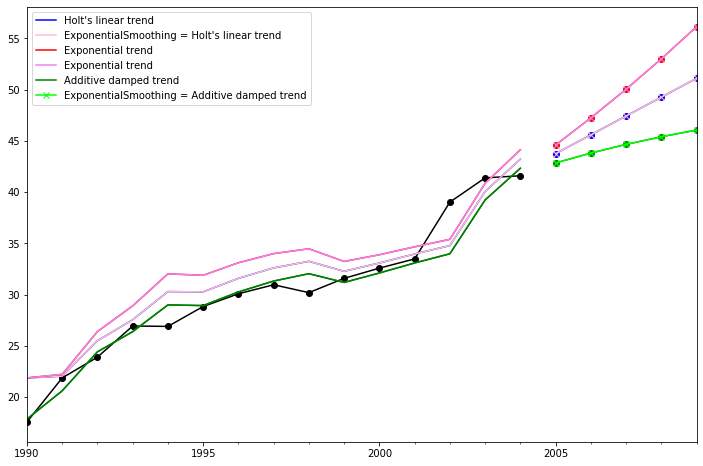

In [61]:
fit1 = Holt(air, exponential=False, damped=False).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(5).rename("Holt's linear trend")

fit1_ = ExponentialSmoothing(air, trend='add', damped=False, seasonal=None).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1_ = fit1_.forecast(5).rename("ExponentialSmoothing = Holt's linear trend")

fit2 = Holt(air, exponential=True , damped=False).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(5).rename("Exponential trend")

fit2_ = ExponentialSmoothing(air, trend='mul', damped=False, seasonal=None).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2_ = fit2_.forecast(5).rename("ExponentialSmoothing = Exponential trend")

fit3 = Holt(air, exponential=False, damped=True ).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(5).rename("Additive damped trend")

fit3_ = ExponentialSmoothing(air, trend='add', damped=True, seasonal=None).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3_ = fit3_.forecast(5).rename("ExponentialSmoothing = Additive damped trend")


fit4 = SimpleExpSmoothing(air).fit(smoothing_level=0.9, optimized=False)
fcast4 = fit4.forecast(5).rename("Simple Exp Smooth")

ax = air.plot(color="black", marker="o", figsize=(12,8))
fit1.fittedvalues.plot(ax=ax, color='blue')
fcast1.plot(ax=ax, color='blue', marker="o", legend=True)

fit1_.fittedvalues.plot(ax=ax, color='pink')
fcast1_.plot(ax=ax, color='pink', marker="x", legend=True)

fit2.fittedvalues.plot(ax=ax, color='red')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)

fit2.fittedvalues.plot(ax=ax, color='violet')
fcast2.plot(ax=ax, color='violet', marker="x", legend=True)

fit3.fittedvalues.plot(ax=ax, color='green')
fcast3.plot(ax=ax, color='green', marker="o", legend=True)

fit3_.fittedvalues.plot(ax=ax, color='green')
fcast3_.plot(ax=ax, color='lime', marker="x", legend=True)

# fit4.fittedvalues.plot(ax=ax, color='orange', legend=True)
# fcast4.plot(ax=ax, color='orange', marker="o", legend=True)